In [ ]:
!pip install -q -r requirements.txt
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
import evaluate
import numpy as np
from torch.nn import functional as F
from typing import Union
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pandas as pd
from collections import Counter
from dataset_class import *
sns.set_style('whitegrid')

import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

violet = '#702b9d'

##### loading

In [3]:
train_path = '/scratch/' + os.environ.get("USER", "") + '/data/jigsaw_training'
val_path =  '/scratch/' + os.environ.get("USER", "") + '/data/jigsaw_validation'
training_file_path = os.path.join(train_path, 'train.csv')
validation_file_path = os.path.join(val_path, 'validation_data.csv')

###### **training**

In [4]:
toxicity_train = pd.read_csv(f'{training_file_path}')
toxicity_train['label'] = np.where(toxicity_train.target > 0.5, 1, 0)

count    1.804874e+06
mean     1.030173e-01
std      1.970757e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e-01
max      1.000000e+00
Name: target, dtype: float64


<AxesSubplot:xlabel='target', ylabel='Count'>

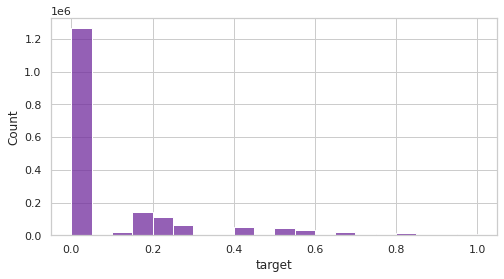

In [16]:
# take a look at distribution
print(toxicity_train.target.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(toxicity_train.target, binwidth = .05, color = violet, ax = ax)

###### **validation**

In [9]:
toxicity_valid = pd.read_csv(f'{validation_file_path}')
print(toxicity_valid.nunique())
print(toxicity_valid.shape)

worker          753
less_toxic    11532
more_toxic    11678
dtype: int64
(30108, 3)


In [13]:
## preprocess validation dataset 
texts = set(toxicity_valid.less_toxic.to_list() + toxicity_valid.more_toxic.to_list())
text2id = {t:id for id,t in enumerate(texts)}
toxicity_valid['less_id'] = toxicity_valid['less_toxic'].map(text2id)
toxicity_valid['more_id'] = toxicity_valid['more_toxic'].map(text2id)
toxicity_valid_grouped = (toxicity_valid.groupby(['less_id', 'more_id']).first()\
                          .reset_index().drop(['less_id', 'more_id'], axis = 1).drop(['worker'], axis = 1))

In [14]:
toxicity_valid_grouped

,less_toxic,more_toxic
0,}}\n\nUNBLOCK: 1. The reason I used sockpuppet...,fdg \n\nyou like it in the ass huh?
1,deserves a knighthood \n\nwell done volkert. ...,"""\n\n""""Notes""""\nWould you care to join issue w..."
2,deserves a knighthood \n\nwell done volkert. ...,WHAT THE HELL IS WRONG WITH YOU WEOTIH:WROIUTH...
3,deserves a knighthood \n\nwell done volkert. ...,Hey\n\nI bet you Quinsareth are gay and like t...
4,"""\nDetails2: I can understand that you would l...","Tard, my IP changes every time I reset my rou..."
...,...,...
15405,hey Jingiby you hate Turkic people because you...,my fucking point exactly. wikipedia should jus...
15406,\nI assume you are not Jewish. Your comment i...,"ok listen, I understand I probably went a litt..."
15407,"""\nOf course you're not sure what point he's m...",I am going to shoot you in the head and laugh...
15408,"Are you a fool? \n\nI am sorry, but you seem ...",==Wow i jsut did a test for this saying bill c...


In [8]:
## make new dataframe
toxic = toxic_dataset(df = toxicity_train, text = toxicity_train.comment_text, 
                      toxicity = toxicity_train.target, size = int(1e5), label = toxicity_train.label, seed = 1011)

toxic.make_dataframe(down_sample = True, make_pairs = True)

toxic.df

paired up ...
made new dataframe ...


,more_toxic_text,less_toxic_text,toxicity_more_toxic,toxicity_less_toxic,labels_more_toxic,labels_less_toxic
0,"Nobody mocked anybody's death, Beavis. You jus...","It's called ""being economical with the truth"" ...",0.600000,0.000000,1,0
1,"Omg, seriously? Natural News? That's one of th...",You will know that negotiations are not going ...,0.400000,0.200000,0,0
2,Same lame arguments we heard in 2010 about Mea...,That bumper is an easy touch up with paint kit...,0.000000,0.000000,0,0
3,Truth is allie is the sore loser. Still hasn'...,He won't do jail time.,0.500000,0.000000,0,0
4,"So you do want gays to live lonely lives, with...",There is a process called hard love. This is ...,0.300000,0.200000,0,0
...,...,...,...,...,...,...
99995,"You ought to acknowledge, then, that your last...",I feel for the family in their quest for answe...,0.300000,0.166667,0,0
99996,Not even 2 months in office and his administra...,"Did you run out of ""Active"" monikers Edwin. Ha...",0.500000,0.100000,0,0
99997,I find your constant preoccupation with sex an...,More silliness from the sawed off wanna be dic...,0.500000,0.360656,0,0
99998,This reply deserved a genuine response imo.\n....,Wikipedia says etizolam: 'marketed under the b...,0.166667,0.000000,0,0


##### Text cleaning

##### Random Trials

In [ ]:
# take a look at distribution
print(toxicity_train.severe_toxicity.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(toxicity_train.severe_toxicity, binwidth = .05, color = violet, ax = ax)


In [ ]:
train_jtc = pd.read_csv(f'{os.path.join(train_path, "train_jtc.csv")}')
train_jtc.nunique()

In [ ]:
# take a look at distribution
print(train_jtc.toxic.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(train_jtc.toxic, binwidth = .05, color = violet, ax = ax)